In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['pdf.use14corefonts'] = True

import numba
import numba.typed

from pathlib import Path
import tqdm
import sys
import seaborn as sns
import scipy.stats
import os
import joblib
import io
import itertools
import warnings

from brokenaxes import brokenaxes


import polars as pl
pl.Config.set_tbl_rows(100);
pl.Config.set_fmt_str_lengths(50);


In [3]:
sys.path.append(str(Path(os.getcwd()).parent))
from src import liftover, annotate, diagnostics, inference
from src.IDs import *


# Create callset to infer from

In [4]:
rahbari_df = pl.read_csv("/nfs/users/nfs_r/rs42/rs42/git/sperm/configs/Rahbari.tsv", separator='\t')

In [5]:
sudmant_df = (
    pl.read_csv("/nfs/users/nfs_r/rs42/rs42/git/sperm/configs/Sudmant.tsv", separator='\t')
    .with_columns(
        pl.col("sample_set").cast(pl.String),
        pl.col("sample_id").cast(pl.String),
    )
)

In [6]:
reads_filenames = (
    [
        (
            f"/lustre/scratch122/tol/projects/sperm/results/Rahbari_20250212/read_analysis/{sample_set}/{sample_id}/reads/{chrom}/all_reads_structure_annotated.parquet"
        ) 
        for sample_id, sample_set in tqdm.tqdm(rahbari_df.select("sample_id", "sample_set").unique().iter_rows())
        for chrom in aut_chrom_names
    ] + 
    [
        (
            f"/lustre/scratch122/tol/projects/sperm/results/Sudmant_20241121/read_analysis/{sample_set}/{sample_id}/reads/{chrom}/all_reads_structure_annotated.parquet"
        ) 
        for sample_id, sample_set in tqdm.tqdm(sudmant_df.select("sample_id", "sample_set").unique().iter_rows())
        for chrom in aut_chrom_names
    ]
)

9it [00:00, 23388.31it/s]
6it [00:00, 21546.08it/s]


In [7]:
reads_df_list = [pl.scan_parquet(filename) for filename in reads_filenames]


## NCO reads to compare against

In [8]:
%%time
def F(filename):
    return (
        pl.scan_parquet(filename)
        .select(
            'read_name',
            'read_length',
            'chrom',
            'sample_id',
            'grch37_chromosome_size_in_bp',
            'high_quality_snp_positions',
            "high_quality_snp_positions_alleles",
            "high_quality_snps_idx_transitions",
            'CO_active_interval_start',
            'CO_active_interval_end',
            "CO_active_interval_length_bp",
            "CO_active_interval_start_cM",
            "CO_active_interval_end_cM",
            'NCO_active_interval_start',
            'NCO_active_interval_end',
            'NCO_active_interval_length_bp',
            'grch37_reference_start',
            'grch38_reference_start',
            'grch37_reference_end',
            'grch38_reference_end',
            'grch37_reference_start_cM',
            'grch37_reference_end_cM',
            'NCO_active_interval_start_cM',
            'NCO_active_interval_end_cM',
            'CO_active_interval_crossover_prob',
            "full_read_crossover_prob",
            "mid_CO_active_interval_crossover_prob",
            'NCO_active_interval_crossover_prob',
            "NCO_prob_detection_in_CO_active_interval",
            'AA_motif_center_pos',
            'AA_heat',
            'AA_motif_strand',
            'CL4_motif_center_pos',
            'CL4_heat',
            'CL4_motif_strand',
            'is_high_quality_read',
            "min_coverage_hap1",
            "min_coverage_hap2",
            "high_quality_classification_class",
            "snp_positions_on_read", 
            "idx_transitions",
            "high_quality_classification_in_detectable_class",
            "H3K4me3_signal_mean",
            "CTCF_signal_mean",
            "total_mismatches",
            "is_contamination",
        )                  
        .collect()
        .filter(pl.col("high_quality_snp_positions").list.len() >= 3)
        .filter(pl.col("high_quality_classification_class") == "GC")     # REMOVE if you need all        
        .filter("is_high_quality_read")
        .filter(~pl.col("is_contamination"))
        .filter(pl.col("CO_active_interval_crossover_prob") > 0)
    )
    
dense_reads_with_detection_df = pl.concat(
    joblib.Parallel(n_jobs=-1, verbose=1)(
        joblib.delayed(F)(filename) for filename in reads_filenames
    )
)

/nfs/users/nfs_r/rs42/rs42/miniforge3/envs/sperm/lib/python3.11/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

  pid = os.fork()
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.9s
/nfs/users/nfs_r/rs42/rs42/miniforge3/envs/sperm/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short

CPU times: user 976 ms, sys: 998 ms, total: 1.97 s
Wall time: 28.1 s


[Parallel(n_jobs=-1)]: Done 330 out of 330 | elapsed:   28.1s finished


In [9]:
NCO_df = (dense_reads_with_detection_df
    #.filter(pl.col("high_quality_classification_in_detectable_class") == "NCO")
    .filter(pl.col("high_quality_classification_class") == "GC")
    .with_columns(
        grch37_recombining_interval_start_pos = pl.col("grch37_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)),
        grch37_recombining_interval_end_pos = pl.col("grch37_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(-1) + 1),
        grch38_recombining_interval_start_pos = pl.col("grch38_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)),
        grch38_recombining_interval_end_pos = pl.col("grch38_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(-1) + 1),
        grch37_first_converted_marker_pos = pl.col("grch37_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)+1),
        grch38_first_converted_marker_pos = pl.col("grch38_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)+1),
    )
    .with_columns(
        grch37_recombining_interval_length = pl.col("grch37_recombining_interval_end_pos") - pl.col("grch37_recombining_interval_start_pos"),                
        grch38_recombining_interval_length = pl.col("grch38_recombining_interval_end_pos") - pl.col("grch38_recombining_interval_start_pos"),                
    )
)

dfs = []
for [chrom], df in NCO_df.partition_by(by=["chrom"], as_dict=True).items():
    rate_map = annotate.rate_maps[chrom]
    dfs.append(
        df.with_columns(
            grch37_recombining_interval_start_poses_cm = rate_map.get_cumulative_mass(df["grch37_recombining_interval_start_pos"]) * 1e2,
            grch37_recombining_interval_end_poses_cm = rate_map.get_cumulative_mass(df["grch37_recombining_interval_end_pos"]) * 1e2,
            grch37_first_converted_marker_poses_rate = rate_map.get_rate(df["grch37_first_converted_marker_pos"]) * 1e2,
        ).with_columns(
            grch37_recombining_interval_cM = (pl.col("grch37_recombining_interval_end_poses_cm") - pl.col("grch37_recombining_interval_start_poses_cm")),
            grch37_cM_per_bp_across_recombining_interval = (pl.col("grch37_recombining_interval_end_poses_cm") - pl.col("grch37_recombining_interval_start_poses_cm")) / pl.col("grch37_recombining_interval_length"),
        )
    )
    
NCO_df = pl.concat(dfs)

NCO_df = (NCO_df
    .select(
        "read_name",
        (pl.col("full_read_crossover_prob") * 1e2).alias("genetic_length_in_cm"),
        (pl.col("read_length")).alias("genetic_length_in_bp"),
        (
            pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(1)) -
            pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)+1)
        ).alias("lower_bound"),
        (
            pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(1)+1) -
            pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0))
        ).alias("upper_bound"),
        pl.col("idx_transitions").list.diff(null_behavior="drop").list.first().alias("n_converted"),     
    )
    .with_columns(
        (pl.col("genetic_length_in_cm")/(pl.col("genetic_length_in_bp")*1e-6)).alias("read_recomb_rate_in_cm_bp"),
    )
)

In [10]:
#sperm_sample_ids_except_AD = [x for x in rahbari_sample_ids + sudmant_sample_ids if x != 'PD50523b']

In [11]:
%%time
dfs = joblib.Parallel(n_jobs=-1, verbose=1)(
    joblib.delayed(inference.generate_call_set)(
        reads_df, rahbari_sample_ids + sudmant_sample_ids, 10, False, 3, 1
    )
    for reads_df in reads_df_list
)

callset_df = pl.concat([df for df in dfs if len(df)])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.2min


CPU times: user 9.94 s, sys: 22.5 s, total: 32.4 s
Wall time: 3min 29s


[Parallel(n_jobs=-1)]: Done 330 out of 330 | elapsed:  3.5min finished


In [12]:
len(callset_df)

10697874

# Test simulation 

In [59]:
%%time
# 0.994, 28.0, 1250.0
# 0.993, 31.0, 1220.0
#[   1.           71.50300601 1000.        ]

m = 0.993
GC_tract_mean = 31
GC_tract_mean2 = 1220
    
idf = callset_df[::10]

# res = inference.simulate_read_patterns_probs(
#     numba.typed.List(idf["read_length"].to_numpy()),
#     numba.typed.List(idf["high_quality_snp_positions"].to_numpy()),
#     numba.typed.List(idf["between_high_quality_snps_cM"].to_numpy() * 1e-2),
#     numba.typed.List(idf["before_read_cM"].to_numpy() * 1e-2),
#     numba.typed.List(idf["after_read_cM"].to_numpy() * 1e-2),
#     q = 0.114,
#     m = 0.99,
#     GC_tract_mean = 30.5,
#     GC_tract_mean2 = 16842,
#     read_margin_in_bp = 5000,
# )

recomb_rate_for_sim = 1

res = inference.simulate_read_patterns_probs(
    numba.typed.List(idf["read_length"].to_numpy()),
    numba.typed.List(idf["high_quality_snp_positions"].to_numpy()),
    numba.typed.List(idf["between_high_quality_snps_bp"].to_numpy() * recomb_rate_for_sim),
    numba.typed.List(np.repeat(5000 * recomb_rate_for_sim, len(idf))),
    numba.typed.List(np.repeat(5000 * recomb_rate_for_sim, len(idf))),
    q = 0,
    m = m,
    GC_tract_mean = GC_tract_mean,
    GC_tract_mean2 = GC_tract_mean2,
    read_margin_in_bp = 5000,
    allow_flip = False,
)

xxx = idf["high_quality_snp_positions"].to_numpy()

sim_stats_df = pl.DataFrame(
    [(
        # xxx[event_index], 
        # idx_trans,
        idx_trans[1] - idx_trans[0],
        xxx[event_index][idx_trans[1]] - xxx[event_index][idx_trans[0]+1],
        xxx[event_index][idx_trans[1]+1] - xxx[event_index][idx_trans[0]],
    ) 
         for idx_trans, event_index, event_type, tract_type, tract_length in zip(res[0], res[1], res[6], res[7], res[8]) \
         if event_type == 0 and len(idx_trans) == 2],
    orient="row",
    schema=["n_converted", "lower_bound", "upper_bound"],
)

CPU times: user 22.5 s, sys: 14.3 s, total: 36.9 s
Wall time: 19.4 s


In [66]:
sim_idx_transitions = [np.array([], dtype=np.int64) for i in range(len(idf))]
for i, lst in zip(res[1], res[0]):
    sim_idx_transitions[i] = np.array(lst, dtype=np.int64)

n_detected_COs = np.sum([1 for x in sim_idx_transitions if len(x) == 1])
n_detected_NCOs = np.sum([1 for x in sim_idx_transitions if len(x) == 2])

n_detected_NCOs_from_NCOs = np.sum([1 for idx_trans, event_type in zip(res[0], res[6]) if event_type == 0 and len(idx_trans) == 2])
n_detected_COs_from_NCOs = np.sum([1 for idx_trans, event_type in zip(res[0], res[6]) if event_type == 0 and len(idx_trans) == 1])

print("# events:", len(res[0]))
print("# CO events:", res[3])
print("# detected CO events:", n_detected_COs)

print("# NCO events:", res[4])
print("# detected NCO events:", n_detected_NCOs)
print("# detected NCO events from NCOs:", n_detected_NCOs_from_NCOs)
print("# detected CO events from NCOs:", n_detected_COs_from_NCOs)

print("# NCO first comp:", res[5])


# events: 1069788
# CO events: 0
# detected CO events: 3735
# NCO events: 1069788
# detected NCO events: 10645
# detected NCO events from NCOs: 10645
# detected CO events from NCOs: 3735
# NCO first comp: 1062212
estimated percent of obs NCO: 0.9950569645574636


In [67]:
print("Frac NCO detected:", n_detected_NCOs/res[4])

Frac NCO detected: 0.009950569645574637


In [68]:
shorts = np.array([tract_length \
     for idx_trans, event_type, tract_type, tract_length in zip(res[0], res[6], res[7], res[8]) \
     if event_type == 0 and tract_type == 1])

longs = np.array([tract_length \
     for idx_trans, event_type, tract_type, tract_length in zip(res[0], res[6], res[7], res[8]) \
     if event_type == 0 and tract_type == 0])

shorts_frac_detected = np.array([(len(idx_trans) > 0) \
     for idx_trans, event_type, tract_type, tract_length in zip(res[0], res[6], res[7], res[8]) \
     if event_type == 0 and tract_type == 1]).mean()

long_frac_detected = np.array([(len(idx_trans) > 0) \
     for idx_trans, event_type, tract_type, tract_length in zip(res[0], res[6], res[7], res[8]) \
     if event_type == 0 and tract_type == 0]).mean()

shorts_n_snps_detected = np.array([len(idx_trans) \
     for idx_trans, event_type, tract_type, tract_length in zip(res[0], res[6], res[7], res[8]) \
     if event_type == 0 and tract_type == 1])

long_n_snps_detected = np.array([len(idx_trans) \
     for idx_trans, event_type, tract_type, tract_length in zip(res[0], res[6], res[7], res[8]) \
     if event_type == 0 and tract_type == 0])



In [69]:
print(
    "Fraction of detected NCOs coming from longs:",
    len(np.nonzero(long_n_snps_detected)[0]) / (len(np.nonzero(long_n_snps_detected)[0]) + len(np.nonzero(shorts_n_snps_detected)[0]))
)

Fraction of detected NCOs coming from longs: 0.11974965229485396


In [73]:
import statsmodels.stats.proportion

statsmodels.stats.proportion.proportion_confint(
    len(np.nonzero(long_n_snps_detected)[0]) ,
    (len(np.nonzero(long_n_snps_detected)[0]) + len(np.nonzero(shorts_n_snps_detected)[0])),
    method="beta",
)

(0.11448568782416484, 0.12516799595317618)

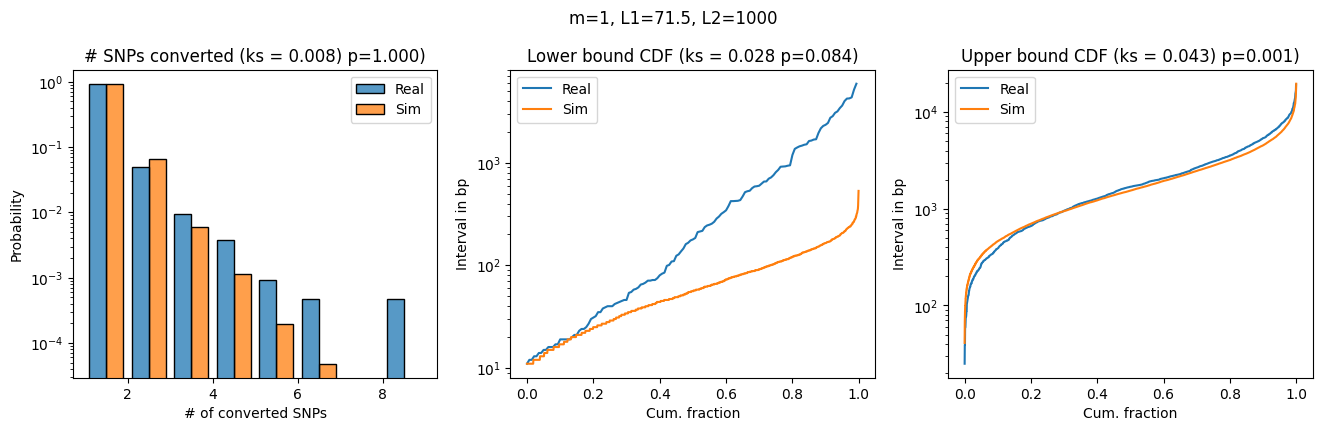

In [35]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

sns.histplot(
    [
        NCO_df["n_converted"].alias("Real"),
        sim_stats_df["n_converted"].alias("Sim"),
    ],
    ax = axs[0],
    stat="probability",
    common_norm=False,
    multiple = "dodge",
    shrink = 0.8,
    bins = np.arange(1, 10),
);

st = scipy.stats.ks_2samp(NCO_df["n_converted"], sim_stats_df["n_converted"]).statistic
ksp = scipy.stats.ks_2samp(NCO_df["n_converted"], sim_stats_df["n_converted"]).pvalue
axs[0].set_title(f"# SNPs converted (ks = {st:1.3f}) p={ksp:1.3f})");
axs[0].set_xlabel("# of converted SNPs");
axs[0].set_yscale("log");

lb = (
    (NCO_df
        .filter(pl.col("lower_bound") > 0)
        ["lower_bound"].sort()
    )
)

axs[1].plot(
    np.arange(len(lb)) / len(lb),
    lb,
    label="Real"
)

slb = (
    (sim_stats_df
        .filter(pl.col("lower_bound") > 0)
        ["lower_bound"].sort()
    )
)

axs[1].plot(
    np.arange(len(slb)) / len(slb),
    slb,
    label="Sim"
)


st = scipy.stats.ks_2samp(NCO_df["lower_bound"], sim_stats_df["lower_bound"]).statistic
ksp = scipy.stats.ks_2samp(NCO_df["lower_bound"], sim_stats_df["lower_bound"]).pvalue
axs[1].set_title(f"Lower bound CDF (ks = {st:1.3f} p={ksp:1.3f})");
axs[1].set_xlabel("Cum. fraction");
axs[1].set_ylabel("Interval in bp");
axs[1].set_yscale("log");
axs[1].legend();

ub = (
    (NCO_df
        .filter(pl.col("upper_bound") > 0)
        ["upper_bound"].sort()
    )
)

axs[2].plot(
    np.arange(len(ub)) / len(ub),
    ub,
    label="Real"
)

sub = (
    (sim_stats_df
        .filter(pl.col("upper_bound") > 0)
        ["upper_bound"].sort()
    )
)

axs[2].plot(
    np.arange(len(sub)) / len(sub),
    sub,
    label="Sim"
)

st = scipy.stats.ks_2samp(NCO_df["upper_bound"], sim_stats_df["upper_bound"]).statistic
ksp = scipy.stats.ks_2samp(NCO_df["upper_bound"], sim_stats_df["upper_bound"]).pvalue
axs[2].set_title(f"Upper bound CDF (ks = {st:1.3f}) p={ksp:1.3f})");
axs[2].set_xlabel("Cum. fraction");
axs[2].set_ylabel("Interval in bp");
axs[2].set_yscale("log");
axs[2].legend();

fig.suptitle(f"m={m}, L1={GC_tract_mean}, L2={GC_tract_mean2}", y=1.03);

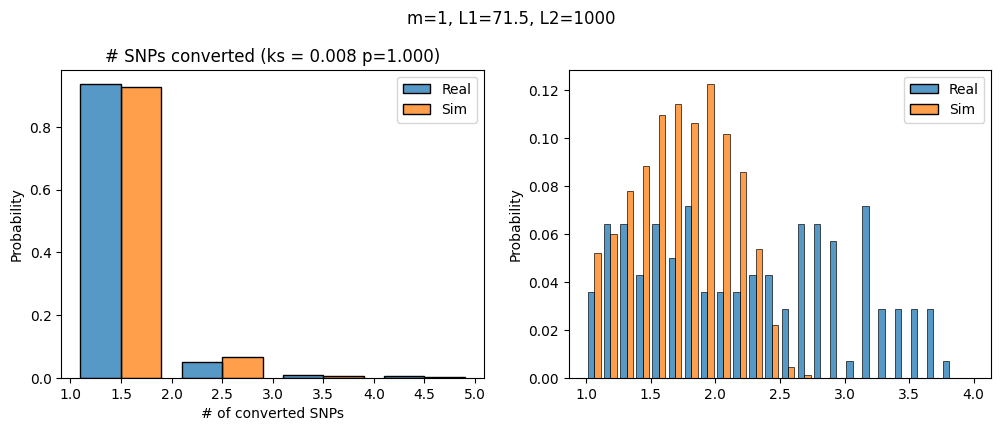

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(
    [
        NCO_df["n_converted"].alias("Real"),
        sim_stats_df["n_converted"].alias("Sim"),
    ],
    ax = axs[0],
    stat="probability",
    common_norm=False,
    multiple = "dodge",
    shrink = 0.8,
    bins = np.arange(1, 6),
);

st = scipy.stats.ks_2samp(NCO_df["n_converted"], sim_stats_df["n_converted"]).statistic
ksp = scipy.stats.ks_2samp(NCO_df["n_converted"], sim_stats_df["n_converted"]).pvalue
axs[0].set_title(f"# SNPs converted (ks = {st:1.3f} p={ksp:1.3f})");
axs[0].set_xlabel("# of converted SNPs");

lb = (
    (NCO_df
        .filter(pl.col("lower_bound") > 0)
        ["lower_bound"].sort()
    )
)


slb = (
    (sim_stats_df
        .filter(pl.col("lower_bound") > 0)
        ["lower_bound"].sort()
    )
)

sns.histplot(
    [
        lb.log(base=10).alias("Real"),
        slb.log(base=10).alias("Sim"),
    ],
    ax = axs[1],
    stat="probability",
    common_norm=False,
    multiple = "dodge",
    shrink = 0.8,
    bins = np.linspace(1, 4, 25), #np.arange(1, 10),
);

#axs[1].set_yscale("log");


fig.suptitle(f"m={m}, L1={GC_tract_mean}, L2={GC_tract_mean2}", y=1.03);

# ABC

In [322]:
def simulate_and_stats(
    idf,
    m,
    GC_tract_mean,
    GC_tract_mean2,
):  
    recomb_rate_for_sim = 1
    
    # bounds = np.linspace(0, len(idf), 32, dtype=int)
    # L = bounds[:-1]
    # U = bounds[1:]

    res = inference.simulate_read_patterns_probs(
            numba.typed.List(idf["read_length"].to_numpy()),
            numba.typed.List(idf["high_quality_snp_positions"].to_numpy()),
            numba.typed.List(idf["between_high_quality_snps_bp"].to_numpy() * recomb_rate_for_sim),
            numba.typed.List(np.repeat(5000 * recomb_rate_for_sim, len(idf))),
            numba.typed.List(np.repeat(5000 * recomb_rate_for_sim, len(idf))),
            q = 0,
            m = m,
            GC_tract_mean = GC_tract_mean,
            GC_tract_mean2 = GC_tract_mean2,
            read_margin_in_bp = 5000,
            allow_flip = False,
        )
    
    # all_res = joblib.Parallel(n_jobs=-1, verbose=1)(
    #     joblib.delayed(F)(idf[l:u]) for l,u in zip(L, U)
    # )
        

    xxx = idf["high_quality_snp_positions"].to_numpy()

    sim_stats_df = pl.DataFrame(
        [(
            # xxx[event_index], 
            # idx_trans,
            idx_trans[1] - idx_trans[0],
            xxx[event_index][idx_trans[1]] - xxx[event_index][idx_trans[0]+1],
            xxx[event_index][idx_trans[1]+1] - xxx[event_index][idx_trans[0]],
        )
             for idx_trans, event_index, event_type, tract_type, tract_length in zip(res[0], res[1], res[6], res[7], res[8]) \
             if event_type == 0 and len(idx_trans) == 2],
        orient="row",
        schema=["n_converted", "lower_bound", "upper_bound"],
    )
    
    return sim_stats_df
    

In [277]:
import scipy.stats

original_stats = NCO_df.select("n_converted", "lower_bound", "upper_bound")

def ABC(
    df,
    original_stats,
    prob_GC_component_range,
    GC_tract_mean_range,
    GC_tract_mean2_range,
    basinhopping_iters = 50,
    x0 = None,
):    
    def compare_stats(original_stats, current_stats):
        S1 = scipy.stats.ks_2samp(original_stats["n_converted"], current_stats["n_converted"]).statistic
        S2 = scipy.stats.ks_2samp(original_stats["lower_bound"], current_stats["lower_bound"]).statistic
        S3 = scipy.stats.ks_2samp(original_stats["upper_bound"], current_stats["upper_bound"]).statistic
        
        S = S1 + S2 + S3

        return S


    def minimizeme(x, df, original_stats):
        current_stats = simulate_and_stats(
            df,
            x[0],
            x[1],
            x[2],
        )

        S = compare_stats(original_stats, current_stats)

        with np.printoptions(precision=3, suppress=True):
            print(x, S)
            
        return S

        
    bounds = [prob_GC_component_range, GC_tract_mean_range, GC_tract_mean2_range]
    lower_bounds = np.array([x[0] for x in bounds])
    upper_bounds = np.array([x[1] for x in bounds])
    stepsize = np.diff(np.array(bounds), axis=1).ravel() / 20
    
    if x0 is None:
        x0 = [
            np.mean(prob_GC_component_range), 
            np.mean(GC_tract_mean_range), 
            np.mean(GC_tract_mean2_range), 
        ]
        
    resbrute = scipy.optimize.brute(
        func = minimizeme, 
        ranges = bounds, 
        args=(df, original_stats), 
        Ns=10, 
        full_output=True, 
        finish=None, 
        disp=False, 
        workers=1,
    )
    
    return resbrute
    
#     def take_step(x):
#         min_step = np.maximum(lower_bounds - x, -stepsize)
#         max_step = np.minimum(upper_bounds - x, stepsize)

#         random_step = np.random.uniform(low=min_step, high=max_step, size=x.shape)
#         xnew = x + random_step
#         print("hopped to", xnew)
        
#         return xnew
    
#     res = scipy.optimize.basinhopping(
#         func = minimizeme,
#         x0 = x0,      
#         take_step=take_step,
#         minimizer_kwargs={
#             "method": "Nelder-Mead", 
#             "bounds": bounds,
#             "options": {"maxiter": 10000, "xatol": 1e-3},            
#             "args": (df, original_stats),
#         },
#         niter=basinhopping_iters,
#         niter_success=5,
#         disp=True,
#     )
    
    # res = scipy.optimize.minimize(
    #     fun = minimizeme,
    #     x0 = x0,
    #     method = "Nelder-Mead",
    #     args = (df, original_stats),
    #     bounds = bounds,
    #     options={'xatol': 1e-3},
    # )
    
    return res


In [ ]:
abc_res = ABC(
    callset_df[::100],
    original_stats,
    [0.97, 1],
    [20, 50],
    [500, 1500],
    x0 = [0.99, 30, 1000],
)

In [306]:
abc_res[0]

array([  0.99333333,  40.        , 944.44444444])

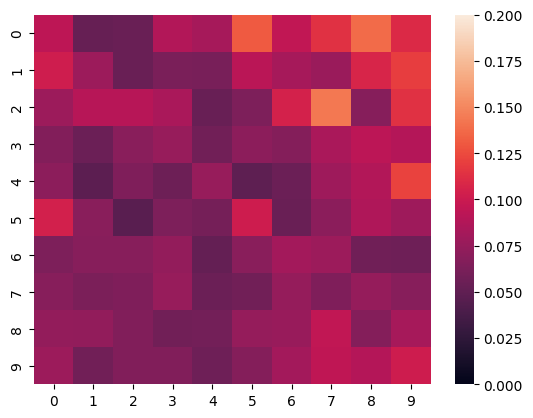

In [304]:
sns.heatmap(
    abc_res[3][6,:,:],
    vmin=0, 
    vmax=0.2,
);

# Read snakemake data

In [10]:
def F(m, L1, L2):
    return (
        (m, L1, L2), 
        pl.read_parquet(
            f"/lustre/scratch122/tol/projects/sperm/results/tract_length_inference_sperm_20250407/tract_stats_m={m:1.3f}_L1={L1:1.3f}_L2={L2:1.3f}.parquet"
        )
    )

ddd = joblib.Parallel(n_jobs=-1, verbose=1)(
    joblib.delayed(F)(m, L1, L2) \

    # for m in np.linspace(0.97, 1, 11)
    # for L1 in np.linspace(10, 100, 11)
    # for L2 in np.linspace(500, 2000, 21)
    for m in np.linspace(0.988, 0.994, 7)
    for L1 in np.linspace(20, 50, 31)
    for L2 in np.linspace(650, 1550, 31)    
)
           
opt_res = dict(ddd)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 804 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 1504 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 2404 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 3504 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 4804 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done 6304 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done 6696 out of 6727 | elapsed:   49.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 6727 out of 6727 | elapsed:   49.5s finished


In [21]:
def F(m, L1, L2):
    return (
        (m, L1, L2), 
        pl.read_parquet(
            f"/lustre/scratch122/tol/projects/sperm/results/tract_length_inference_sperm_20250407/tract_stats_m={m:1.3f}_L1={L1:1.3f}_L2={L2:1.3f}.parquet"
        )
    )

ddd = joblib.Parallel(n_jobs=-1, verbose=1)(
    joblib.delayed(F)(m, L1, L2) \

    # for m in np.linspace(0.97, 1, 11)
    # for L1 in np.linspace(10, 100, 11)
    # for L2 in np.linspace(500, 2000, 21)
    for m in [1.0]
    for L1 in np.linspace(10, 1000, 500)
    for L2 in [1000]
)
           
opt_res_single = dict(ddd)

[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:   15.0s
[Parallel(n_jobs=32)]: Done 386 tasks      | elapsed:   33.6s
[Parallel(n_jobs=32)]: Done 500 out of 500 | elapsed:   44.3s finished


In [11]:
def compare_stats(original_stats, current_stats):
    S1 = scipy.stats.ks_2samp(original_stats["n_converted"], current_stats["n_converted"]).statistic
    S2 = scipy.stats.ks_2samp(original_stats["lower_bound"], current_stats["lower_bound"]).statistic
    S3 = scipy.stats.ks_2samp(original_stats["upper_bound"], current_stats["upper_bound"]).statistic

    S = S1 + S2 + S3

    return S

In [12]:
original_stats = NCO_df.select("n_converted", "lower_bound", "upper_bound")


In [13]:
def fit_stats(original_stats, opt_res, parallelize=True):
    if parallelize:
        opt_scores = joblib.Parallel(n_jobs=16, verbose=0)(
            joblib.delayed(compare_stats)(original_stats, v) for k,v in opt_res.items()
        )
    else:
        opt_scores = [compare_stats(original_stats, v) for k,v in opt_res.items()]
    
    opt_df = pl.DataFrame(
        list(zip([list(np.array(k)) for k in opt_res.keys()], opt_scores)),
        # opt_scores,
        orient="row",
        schema=["params", "score"],
        strict=False,
    )
    
    return opt_df.sort("score", descending=False).head(10)

In [14]:
%%time
fit_stats(original_stats, opt_res)

CPU times: user 30.5 s, sys: 33.9 s, total: 1min 4s
Wall time: 1min 15s


params,score
list[f64],f64
"[0.993, 31.0, 1220.0]",0.039671
"[0.991, 32.0, 890.0]",0.039714
"[0.992, 35.0, 1040.0]",0.039785
"[0.993, 35.0, 1070.0]",0.039941
"[0.993, 38.0, 1160.0]",0.03997
"[0.991, 28.0, 890.0]",0.040128
"[0.989, 32.0, 770.0]",0.040232
"[0.992, 33.0, 980.0]",0.040256
"[0.991, 33.0, 890.0]",0.04028


In [55]:
fit_stats(original_stats, opt_res_single)

params,score
list[f64],f64
"[1.0, 71.503006, 1000.0]",0.074125
"[1.0, 73.486974, 1000.0]",0.074804
"[1.0, 69.519038, 1000.0]",0.075211
"[1.0, 77.45491, 1000.0]",0.076807
"[1.0, 75.470942, 1000.0]",0.077208
"[1.0, 79.438878, 1000.0]",0.07802
"[1.0, 65.551102, 1000.0]",0.078638
"[1.0, 67.53507, 1000.0]",0.078774
"[1.0, 81.422846, 1000.0]",0.07987


In [ ]:
# %%time
# def F():
#     opt_df = fit_stats(
#         NCO_df.select("n_converted", "lower_bound", "upper_bound").sample(fraction=1, with_replacement=True), 
#         opt_res,
#         parallelize=False,
#     )
    
#     return opt_df

# bootstraps = joblib.Parallel(n_jobs=-1, verbose=1, backend="threading")(
#     joblib.delayed(F)() for i in range(32)
# )
# bootstraps = pl.concat([r[0] for r in bootstraps])

# #bootstraps.write_parquet("/lustre/scratch122/tol/projects/sperm/results/tract_length_inference_sperm_20250407/bootstrap_opts.parquet")

In [15]:
def F():
    opt_df = fit_stats(
        NCO_df.select("n_converted", "lower_bound", "upper_bound").sample(fraction=1, with_replacement=True), 
        opt_res,
    )
    
    return opt_df

bootstraps = pl.concat([F()[0] for i in tqdm.trange(100)])

bootstraps.write_parquet("/lustre/scratch122/tol/projects/sperm/results/tract_length_inference_sperm_20250407/bootstrap_opts.parquet")

100%|██████████| 100/100 [1:41:12<00:00, 60.73s/it]


In [11]:
bootstraps = pd.read_parquet("/lustre/scratch122/tol/projects/sperm/results/tract_length_inference_sperm_20250407/bootstrap_opts.parquet")

In [14]:
np.quantile(np.vstack(bootstraps["params"].to_numpy()), q=[0.025, 0.975], axis=0)

array([[9.8800e-01, 2.2000e+01, 6.8000e+02],
       [9.9400e-01, 4.1525e+01, 1.5200e+03]])

In [89]:
bootstraps

,params,score
0,"[0.991, 32.0, 950.0]",0.042560
1,"[0.994, 34.0, 1070.0]",0.048917
2,"[0.993, 35.0, 1070.0]",0.037956
3,"[0.993, 37.0, 1130.0]",0.045126
4,"[0.992, 30.0, 890.0]",0.048682
...,...,...
95,"[0.994, 31.0, 1070.0]",0.036228
96,"[0.989, 31.0, 830.0]",0.042100
97,"[0.993, 27.0, 980.0]",0.058434
98,"[0.994, 28.0, 1100.0]",0.036052


In [38]:
def F():
    opt_df = fit_stats(
        NCO_df.select("n_converted", "lower_bound", "upper_bound").sample(fraction=1, with_replacement=True), 
        opt_res_single,
    )
    
    return opt_df

bootstraps_singles = pl.concat([F()[0] for i in tqdm.trange(100)])

bootstraps_singles.write_parquet("/lustre/scratch122/tol/projects/sperm/results/tract_length_inference_sperm_20250407/bootstrap_opts_single.parquet")



100%|██████████| 100/100 [1:54:12<00:00, 68.52s/it]


ComputeError: cannot write 'Object' datatype to parquet

In [49]:
bootstraps_singles = bootstraps_singles.with_columns(params = pl.Series(list(map(list, bootstraps_singles["params"]))))

TypeError: not yet implemented: Nested object types

Hint: Try setting `strict=False` to allow passing data with mixed types.

In [46]:
bootstraps_singles.write_parquet("/lustre/scratch122/tol/projects/sperm/results/tract_length_inference_sperm_20250407/bootstrap_opts_single.parquet")


In [53]:
np.quantile(np.vstack(bootstraps_singles["params"][0].to_numpy()), q=[0.025, 0.975], axis=0)

array([[   1.        ,   60.54158317, 1000.        ],
       [   1.        ,   89.35871743, 1000.        ]])